#IMPORT NECESSARY LIBRARIES

In [13]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time


time: 547 µs (started: 2024-04-07 16:14:00 +00:00)


In [14]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG19, ResNet50V2, InceptionV3, Xception
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout

time: 759 µs (started: 2024-04-07 16:14:01 +00:00)


In [15]:
from google.colab.patches import cv2_imshow
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

time: 677 µs (started: 2024-04-07 16:14:01 +00:00)


#DATA PREPARATION

##Define runtime

In [16]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.62 s (started: 2024-04-07 16:14:07 +00:00)


##Load Dataset

In [17]:
!gdown "16h_mWdWCsAQeO2cu_AccT1d1pW9WP60t"
!unzip data_ws.zip

Downloading...
From: https://drive.google.com/uc?id=16h_mWdWCsAQeO2cu_AccT1d1pW9WP60t
To: /content/data_ws.zip
100% 21.8M/21.8M [00:00<00:00, 106MB/s]
Archive:  data_ws.zip
replace data_ws/ws_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: time: 2min 11s (started: 2024-04-07 16:14:15 +00:00)


(240, 426, 3)


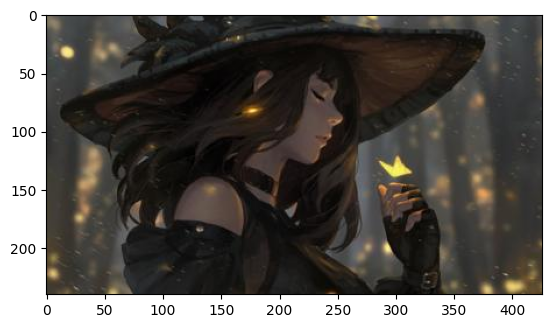

time: 282 ms (started: 2024-04-07 16:16:26 +00:00)


In [18]:
img = cv2.imread('data_ws/ws_0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
del img

In [19]:
# Path to your image folder
data_ws_dir = "/content/data_ws/"

# Get all image file paths
all_images = [os.path.join(data_ws_dir, filename) for filename in os.listdir(data_ws_dir)]

time: 4.34 ms (started: 2024-04-07 16:16:27 +00:00)


In [20]:
def load_images(image_paths):
    images = []
    for img_path in range(len(all_images)):
        img = cv2.imread(f"/content/data_ws/ws_{img_path}.jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)

train_images = load_images(all_images)
images = train_images
print(len(images))

1209
time: 2.39 s (started: 2024-04-07 16:16:27 +00:00)


Test correct index:

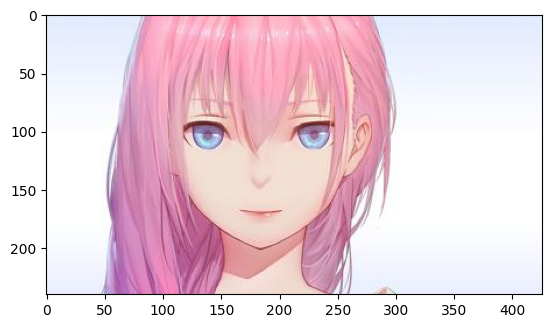

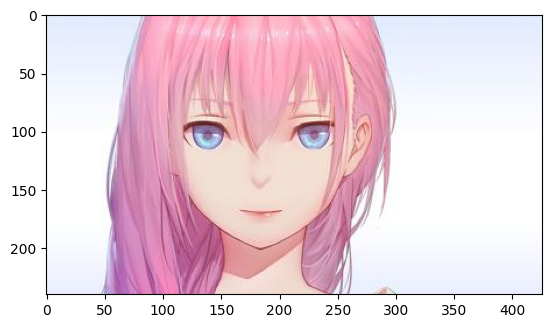

time: 706 ms (started: 2024-04-07 16:16:29 +00:00)


In [21]:
plt.imshow(images[500])
plt.show()
img = cv2.imread('data_ws/ws_500.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

##Visualize data

In [ ]:
n_clusters = 19
n_components = 2
random_state = 42

time: 641 µs (started: 2024-04-05 07:35:58 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


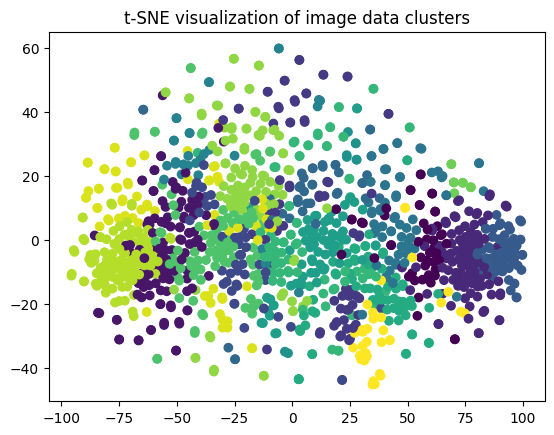

time: 11min 53s (started: 2024-04-05 07:36:12 +00:00)


In [ ]:
# Flatten the images for clustering
visualize_images = images
flattened_images = visualize_images.reshape(visualize_images.shape[0], -1)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)  # Change the number of clusters as needed
kmeans.fit(flattened_images)

# Perform t-SNE dimensionality reduction for visualization
tsne = TSNE(n_components=n_components, random_state=random_state)
reduced_data = tsne.fit_transform(flattened_images)

# Plot the data points in the reduced dimension space
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_)
plt.title('t-SNE visualization of image data clusters')
plt.show()

<ipython-input-22-0a195f04b176>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', n_clusters)


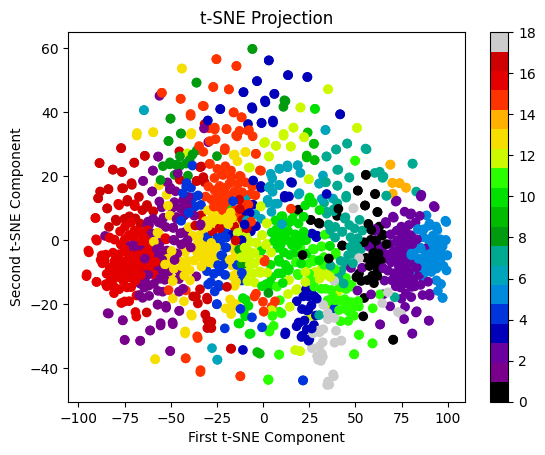

time: 342 ms (started: 2024-04-05 07:48:06 +00:00)


In [ ]:
cmap = plt.cm.get_cmap('nipy_spectral', n_clusters)

# Plot the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap=cmap)
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.title("t-SNE Projection")
plt.colorbar()
plt.show()

In [ ]:
del visualize_images
del n_clusters
del flattened_images
del kmeans
del tsne
del reduced_data

time: 767 µs (started: 2024-04-05 07:49:29 +00:00)


#MODEL IMPLEMENTATION

##Models Initialization

###Load pre-trained models

In [22]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
resnet50v2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
xception = Xception(weights='imagenet', include_top=False, input_shape=(240, 426, 3))

83683744/83683744 [==============================] - 0s 0us/step
time: 10.8 s (started: 2024-04-07 16:16:34 +00:00)


###Define a custom CNN autoencoder model

In [45]:
from tensorflow.keras import regularizers
def custom_cnn_model():
    # Define the Convolutional Autoencoder architecture

    input_img = Input(shape=(240, 426, 3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_1')(input_img)
    x = MaxPooling2D((2, 2), padding='same', name='Encoding_MaxPooling2D_1')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_2')(x)
    x = MaxPooling2D((2, 2), padding='same', name='Encoding_MaxPooling2D_2')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_3')(x)
    x = MaxPooling2D((2, 2), padding='same', name='Encoding_MaxPooling2D_3')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_4')(x)
    encoded = MaxPooling2D((2, 2), padding='valid', name='Encoding_MaxPooling2D_4')(x)

    # This is the encoded representation of the input
    autoencoder = Model(input_img, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

customCNN = custom_cnn_model()

time: 196 ms (started: 2024-04-07 16:26:21 +00:00)


In [46]:
customCNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 240, 426, 3)]     0         
                                                                 
 Encoding_Conv2D_1 (Conv2D)  (None, 240, 426, 64)      1792      
                                                                 
 Encoding_MaxPooling2D_1 (M  (None, 120, 213, 64)      0         
 axPooling2D)                                                    
                                                                 
 Encoding_Conv2D_2 (Conv2D)  (None, 120, 213, 128)     73856     
                                                                 
 Encoding_MaxPooling2D_2 (M  (None, 60, 107, 128)      0         
 axPooling2D)                                                    
                                                                 
 Encoding_Conv2D_3 (Conv2D)  (None, 60, 107, 256)      2951

## Set models' name

In [25]:
vgg19_name = 'vgg19'
resnet50v2_name = 'resnet50'
inceptionv3_name = 'inceptionv3'
xception_name = 'xception'
customCNN_name = 'customCNN'

time: 683 µs (started: 2024-04-07 16:16:45 +00:00)


##Model works

In [26]:
def extract_features(input_array, model_name):
    if model_name == vgg19_name:
        return vgg19.predict(input_array)

    elif model_name == resnet50v2_name:
        return resnet50v2.predict(input_array)

    elif model_name == inceptionv3_name:
        return inceptionv3.predict(input_array)

    elif model_name == xception_name:
        return xception.predict(input_array)

    elif model_name == customCNN_name:
        return customCNN.predict(input_array)

    else: return

time: 626 µs (started: 2024-04-07 16:16:45 +00:00)


In [27]:
def kNN_model(train_features_flat, n_neighbors):
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    knn.fit(train_features_flat)

time: 436 µs (started: 2024-04-07 16:16:45 +00:00)


In [28]:
def tSNE_features(model_name, train_features_flat):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(train_features_flat)
    plt.figure(figsize=(10, 7))
    plt.title(f't-SNE Visualization for {model_name}')
    plt.scatter(tsne_results[1:, 0], tsne_results[1:, 1], label='Training Images')
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], label='Input Image', c='red')
    plt.legend()
    plt.show()

time: 699 µs (started: 2024-04-07 16:16:45 +00:00)


#DEFINE FUNCTIONS

##Compute similarity

In [29]:
# cossine similarity
def compute_cosine_similarity(image1, image2):

    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Flatten images into 1D arrays
    vector1 = gray_image1.flatten().astype(float)
    vector2 = gray_image2.flatten().astype(float)

    vector1 = vector1.reshape(1, -1)
    vector2 = vector2.reshape(1, -1)
    # Compute cosine similarity
    cossim = cosine_similarity(vector1,vector2)

    return cossim[0][0]

time: 823 µs (started: 2024-04-07 16:17:19 +00:00)


In [30]:
# structural similarity
def compute_ssim(image1, image2):
    # Convert the images to grayscale
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Compute SSIM between two images
    return ssim(image1_gray, image2_gray)

time: 612 µs (started: 2024-04-07 16:17:19 +00:00)


In [31]:
# histogram similarity
def compute_histogram_similarity(image1, image2):
    # Compute the color histograms of the two images
    hist1 = cv2.calcHist([image1], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([image2], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    # Normalize the histograms
    cv2.normalize(hist1, hist1)
    cv2.normalize(hist2, hist2)

    # Compute the correlation between the two histograms
    correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    return correlation

time: 785 µs (started: 2024-04-07 16:17:19 +00:00)


In [32]:
def compute_all_score(input_image_path, similar_image_indexs):
  image1 = preprocessing_input_image(input_image_path)
  results = []
  for i in similar_image_indexs:
    image2 = images[i]
    cossim = compute_cosine_similarity(image1, image2)
    ssim = compute_ssim(image1, image2)
    hissim = compute_histogram_similarity(image1, image2)
    dic = {"filename":f"ws_{i}.jpg","cossim":cossim,"ssim":ssim,"hissim":hissim}
    results.append(dic)
  return results


time: 634 µs (started: 2024-04-07 16:17:19 +00:00)


## Preprocessing


In [33]:
def get_features_flatten(model_name,images):
  start_time = time.time()
  train_features = extract_features(images, model_name)
  end_time = time.time()
  print(f"Time taken for feature extraction: {end_time - start_time} seconds")
  print(f"Using {model_name}, we get {train_features.shape}")
  train_features_flat = train_features.reshape(train_features.shape[0], -1)
  return train_features_flat

time: 590 µs (started: 2024-04-07 16:17:19 +00:00)


In [34]:
def preprocessing_input_image(input_image_path):
  img = cv2.imread(input_image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (426, 240))
  return img


time: 517 µs (started: 2024-04-07 16:17:19 +00:00)


##Visualization

In [35]:
def visualize_the_images(input_image_path, similar_image_indexs, similarity_scores):
  original_image = preprocessing_input_image(input_image_path)
  plt.figure(figsize=(16, 8))
  # Plot original image
  plt.subplot(2, 6, 1)
  plt.imshow(original_image)
  plt.title(f'Original Image\n{input_image_path}')
  plt.axis('off')

  # Plot similar images
  for i, idx in enumerate(similar_image_indexs):
        similar_image = images[idx]
        plt.subplot(2, 6, i + 7)
        plt.imshow(similar_image)
        plt.title(f'Cosine similarity: {similarity_scores[i]["cossim"]*100:.2f}%\nStructural similarity: {similarity_scores[i]["ssim"]*100:.2f}%\nHistogram similarity: {similarity_scores[i]["hissim"]*100:.2f}%\n{similarity_scores[i]["filename"]}')
        plt.axis('off')

  plt.tight_layout()
  plt.show()




time: 873 µs (started: 2024-04-07 16:17:19 +00:00)


In [36]:
def visualize_the_histogram(input_image_path, similar_image_indexs,similarity_scores):
  original_image = preprocessing_input_image(input_image_path)
  plt.figure(figsize=(45, 10))
  plt.subplot(2, 7, 1)
  plt.imshow(original_image)
  plt.title(f'Original Image\n{input_image_path}')
  plt.axis('off')
  plt.subplot(2, 7, 8)
  for i, color in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([original_image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
  plt.title('Original Image RGB Histogram')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')


  for i, idx in enumerate(similar_image_indexs):
    plt.subplot(2, 7,i+2)
    plt.title(f'Cosine similarity: {similarity_scores[i]["cossim"]*100:.2f}%\nStructural similarity: {similarity_scores[i]["ssim"]*100:.2f}%\nHistogram similarity: {similarity_scores[i]["hissim"]*100:.2f}%\n{similarity_scores[i]["filename"]}')
    plt.imshow(images[idx])
    plt.axis('off')
    plt.subplot(2, 7, i+9)
    plt.title(f'Similar Image {i} Histogram')
    for i, color in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([images[idx]], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
  ######## TO DO ADD Ve histogram rieng
  plt.show()

time: 1.72 ms (started: 2024-04-07 16:17:19 +00:00)


In [37]:
def highlight_features(image1, image2):
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)

    # Create a BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match the descriptors
    matches = bf.match(des1, des2)

    # Sort the matches based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw the first 50 matches
    result = cv2.drawMatches(image1, kp1, image2, kp2, matches[:50], None, flags=2)

    return result

time: 719 µs (started: 2024-04-07 16:17:19 +00:00)


In [38]:
def visualize_highlight(input_image_path, similar_image_indexs, similarity_scores):
  original_image = preprocessing_input_image(input_image_path)
  plt.figure(figsize=(25, 5))
  # Plot original image
  plt.subplot(2, 6, 1)
  plt.imshow(original_image)
  plt.title(f'Original Image\n{input_image_path}')
  plt.axis('off')

  # Plot similar images
  for i, idx in enumerate(similar_image_indexs):
        similar_image = images[idx]
        highlighted_image = highlight_features(original_image, similar_image)
        plt.subplot(2, 6, i + 7)
        plt.imshow(highlighted_image)
        plt.title(f'Cosine similarity: {similarity_scores[i]["cossim"]*100:.2f}%\nStructural similarity: {similarity_scores[i]["ssim"]*100:.2f}%\nHistogram similarity: {similarity_scores[i]["hissim"]*100:.2f}%\n{similarity_scores[i]["filename"]}')
        plt.axis('off')

  plt.tight_layout()
  plt.show()

time: 992 µs (started: 2024-04-07 16:17:19 +00:00)


##Input image

In [39]:
def image_similarity(input_image_path,model_name,all_features, n_neighbors):
  input_image = preprocessing_input_image(input_image_path)

  input_image = np.expand_dims(input_image, axis=0)
  input_features = extract_features(input_image, model_name)
  input_features_flat = input_features.reshape(input_features.shape[0], -1)
  # Train a k-NN model
  knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
  knn.fit(all_features)

  start_time = time.time()

  distances, indices = knn.kneighbors(input_features_flat, n_neighbors=6)
  end_time = time.time()

  time_taken = end_time - start_time
  print(f"Time taken for prediction: {time_taken} seconds")
  #silhouette = silhouette_score(all_features, input_features_flat)
  #davies_bouldin = davies_bouldin_score(all_features, input_features_flat)
  #calinski_harabasz = calinski_harabasz_score(all_features, input_features_flat)

  #print(f"Silhouette Score: {silhouette}")
  #print(f"Davies-Bouldin Index: {davies_bouldin}")
  #print(f"Calinski-Harabasz Index: {calinski_harabasz}")
  return indices[0]


time: 787 µs (started: 2024-04-07 16:17:19 +00:00)


#TESING MODELS

##Feature extraction

In [47]:
import pickle
def store_features(input_array):
    model_names = ['vgg19','resnet50','inceptionv3','xception','customCNN']
    features_dict = {}

    for model_name in model_names:
        features = get_features_flatten( model_name,input_array)
        if features is not None:
            with open(f"/content/drive/MyDrive/Pickle/{model_name}_all_features.pkl", 'wb') as f:
                pickle.dump(features, f)

store_features(images)

38/38 [==============================] - 11s 296ms/step
Time taken for feature extraction: 21.307188987731934 seconds
Using vgg19, we get (1209, 7, 13, 512)
38/38 [==============================] - 6s 154ms/step
Time taken for feature extraction: 11.092413902282715 seconds
Using resnet50, we get (1209, 8, 14, 2048)
38/38 [==============================] - 4s 112ms/step
Time taken for feature extraction: 6.2546234130859375 seconds
Using inceptionv3, we get (1209, 6, 11, 2048)
38/38 [==============================] - 9s 236ms/step
Time taken for feature extraction: 21.35185742378235 seconds
Using xception, we get (1209, 8, 14, 2048)
38/38 [==============================] - 6s 104ms/step
Time taken for feature extraction: 11.286916494369507 seconds
Using customCNN, we get (1209, 15, 27, 512)
time: 1min 41s (started: 2024-04-07 16:26:43 +00:00)


In [ ]:
model_name = customCNN_name
number_neighbors = 9

features = get_features_flatten(model_name,images)


## wait for gpu

38/38 [==============================] - 9s 135ms/step
Time taken for feature extraction: 22.59525775909424 seconds
Using customCNN, we get (1209, 240, 432, 3)
time: 22.6 s (started: 2024-04-05 16:12:22 +00:00)


##Get test images

In [ ]:
!gdown "1Aol-xFrXTZ0SlF4nFwsyWqHdhaHKdEqn"
!unzip test_data.zip
# Get all image file paths
test_dir = "/content/test_data"
all_images_test = [os.path.join(data_ws_dir, filename) for filename in os.listdir(data_ws_dir)]
test_images = []
for img_path in all_images_test:
        test_img = cv2.imread(img_path)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        test_images.append(test_img)
test_images = np.array(test_images)


##Test the model

/content/101156.jfif
1/1 [==============================] - 0s 20ms/step
Time taken for prediction: 2.9366705417633057 seconds
      filename    cossim      ssim    hissim
0   ws_726.jpg  0.988780  0.867175  0.992199
1  ws_1137.jpg  0.766623  0.101207 -0.096454
2   ws_426.jpg  0.816084  0.223924  0.994615
3  ws_1188.jpg  0.640238  0.143962 -0.152542
4  ws_1143.jpg  0.625195  0.094309  0.788718
5  ws_1155.jpg  0.708536  0.128654 -0.147420
customCNN


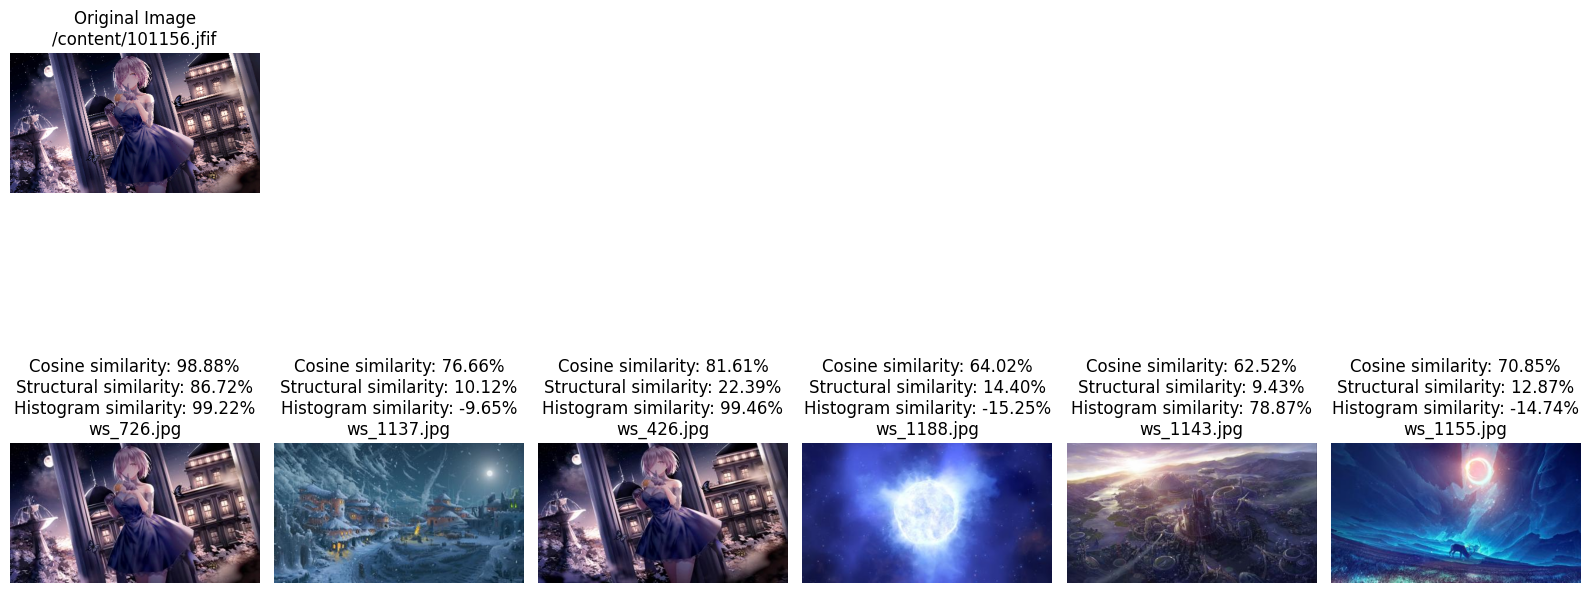

time: 4.57 s (started: 2024-04-05 16:17:34 +00:00)


In [ ]:
input_image_path = "/content/101156.jfif"
print(input_image_path)
similiar_image_indices = image_similarity(input_image_path,model_name, features, number_neighbors )

results = compute_all_score(input_image_path, similiar_image_indices)

print(pd.DataFrame(results))
print()
print(model_name)
visualize_the_images(input_image_path, similiar_image_indices, results)


###Plot histogram

customCNN


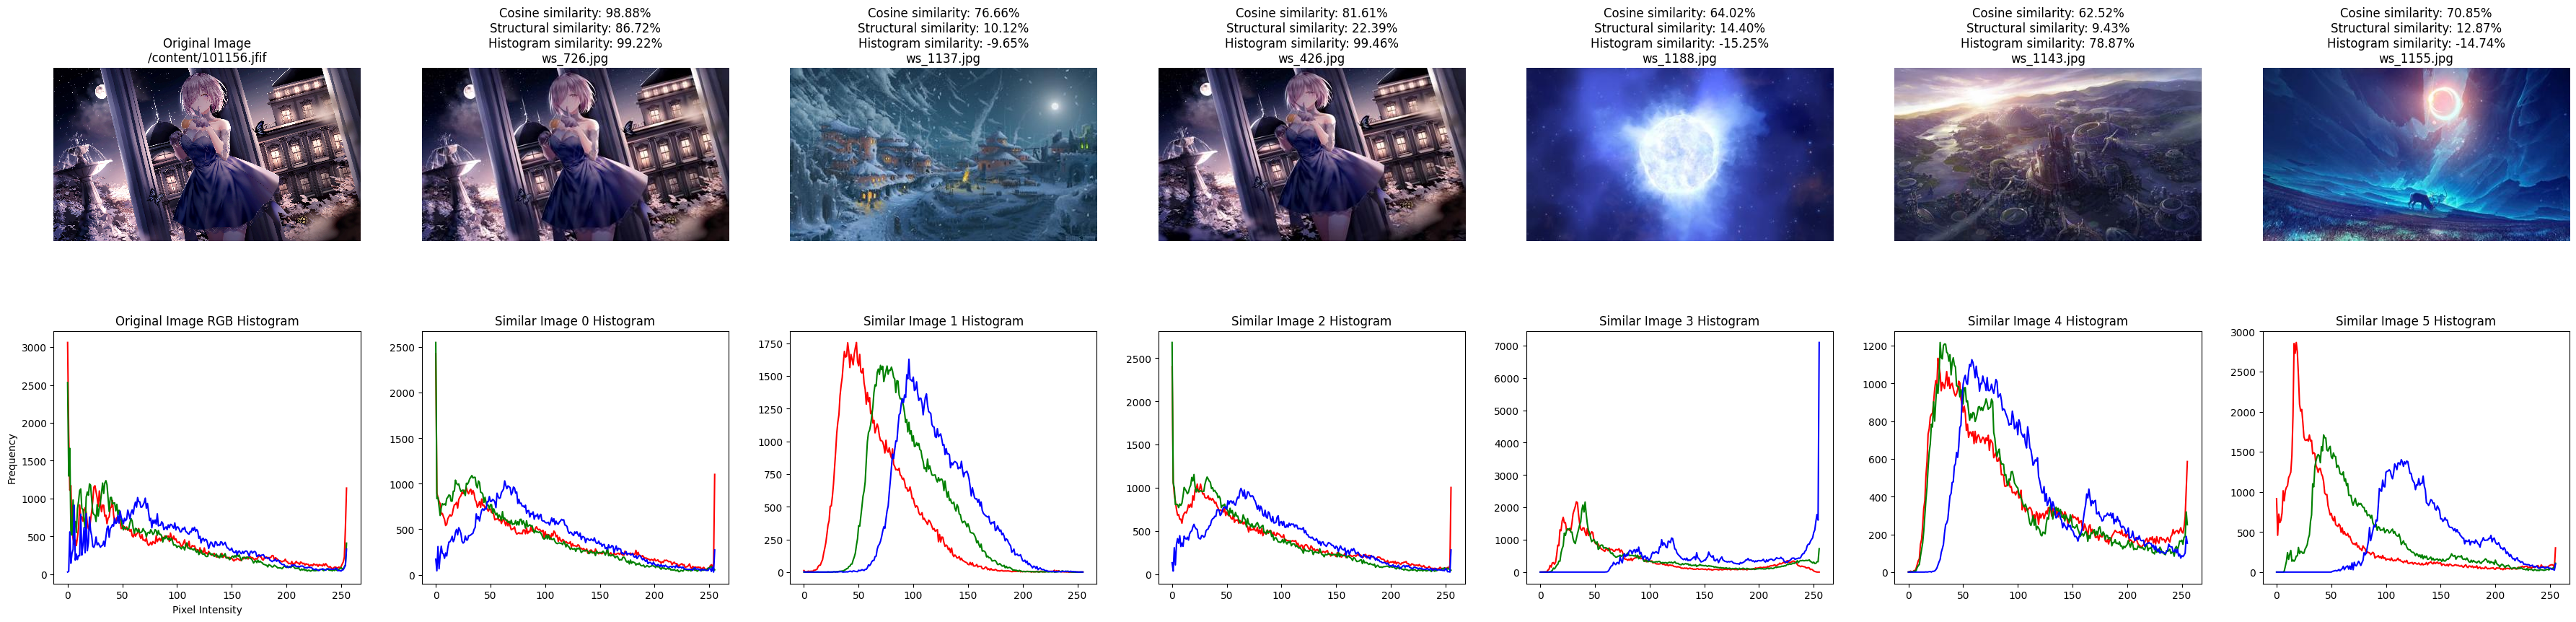

time: 2.21 s (started: 2024-04-05 16:17:52 +00:00)


In [ ]:
print(model_name)
visualize_the_histogram(input_image_path, similiar_image_indices, results)

###Plot highlighted parts

customCNN


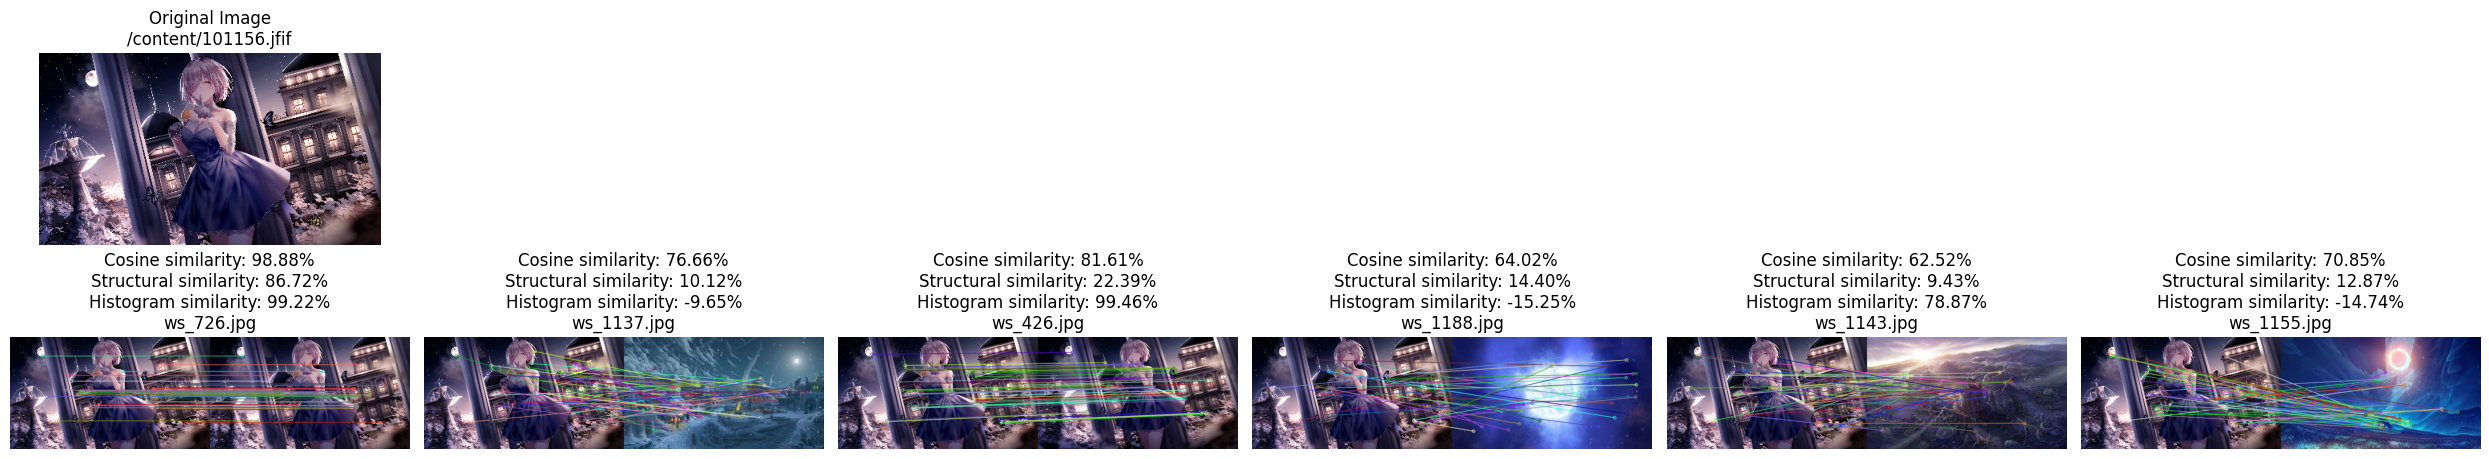

time: 1.03 s (started: 2024-04-05 16:19:07 +00:00)


In [ ]:
print(model_name)
visualize_highlight(input_image_path, similiar_image_indices, results)

## Pretest by set

In [ ]:
random.seed(42)
# Get 120 random elements from the list
test_set = random.sample(all_images, 121)
print(test_set)


big_results = pd.DataFrame()
for i in test_set:
  similiar_image_indices = image_similarity(i,model_name, features, number_neighbors )
  results = compute_all_score(i, similiar_image_indices)
  # Remove the first element because we use the same data
  results = pd.DataFrame(results[1:])
  big_results = pd.concat([big_results,results])


print(big_results)
print(f"Using {model_name} :")
print(f"Average Cosine Similarity : {np.mean(big_results['cossim'])*100}%")
print(f"Average Structural Similarity : {np.mean(big_results['ssim'])*100}%")
print(f"Average Histogram Similarity : {np.mean(np.abs(big_results['hissim']))*100}%")


['/content/data_ws/ws_988.jpg', '/content/data_ws/ws_32.jpg', '/content/data_ws/ws_791.jpg', '/content/data_ws/ws_305.jpg', '/content/data_ws/ws_704.jpg', '/content/data_ws/ws_1164.jpg', '/content/data_ws/ws_948.jpg', '/content/data_ws/ws_363.jpg', '/content/data_ws/ws_1130.jpg', '/content/data_ws/ws_302.jpg', '/content/data_ws/ws_328.jpg', '/content/data_ws/ws_484.jpg', '/content/data_ws/ws_1044.jpg', '/content/data_ws/ws_268.jpg', '/content/data_ws/ws_47.jpg', '/content/data_ws/ws_218.jpg', '/content/data_ws/ws_249.jpg', '/content/data_ws/ws_1092.jpg', '/content/data_ws/ws_42.jpg', '/content/data_ws/ws_707.jpg', '/content/data_ws/ws_298.jpg', '/content/data_ws/ws_724.jpg', '/content/data_ws/ws_23.jpg', '/content/data_ws/ws_536.jpg', '/content/data_ws/ws_388.jpg', '/content/data_ws/ws_475.jpg', '/content/data_ws/ws_678.jpg', '/content/data_ws/ws_862.jpg', '/content/data_ws/ws_582.jpg', '/content/data_ws/ws_1083.jpg', '/content/data_ws/ws_1054.jpg', '/content/data_ws/ws_1059.jpg', '/co

### Custom CNN

In [ ]:
random.seed(42)
# Get 120 random elements from the list
test_set = random.sample(all_images, 121*2)
print(test_set)


big_results = pd.DataFrame()
for i in test_set:
  similiar_image_indices = image_similarity(i,model_name, features, number_neighbors )
  results = compute_all_score(i, similiar_image_indices)
  # Remove the first element because we use the same data
  results = pd.DataFrame(results[1:])
  big_results = pd.concat([big_results,results])


print(big_results)
print(f"Using {model_name} :")
print(f"Average Cosine Similarity : {np.mean(big_results['cossim'])*100}%")
print(f"Average Structural Similarity : {np.mean(big_results['ssim'])*100}%")
print(f"Average Histogram Similarity : {np.mean(np.abs(big_results['hissim']))*100}%")

['/content/data_ws/ws_988.jpg', '/content/data_ws/ws_32.jpg', '/content/data_ws/ws_791.jpg', '/content/data_ws/ws_305.jpg', '/content/data_ws/ws_704.jpg', '/content/data_ws/ws_1164.jpg', '/content/data_ws/ws_948.jpg', '/content/data_ws/ws_363.jpg', '/content/data_ws/ws_1130.jpg', '/content/data_ws/ws_302.jpg', '/content/data_ws/ws_328.jpg', '/content/data_ws/ws_484.jpg', '/content/data_ws/ws_1044.jpg', '/content/data_ws/ws_268.jpg', '/content/data_ws/ws_47.jpg', '/content/data_ws/ws_218.jpg', '/content/data_ws/ws_249.jpg', '/content/data_ws/ws_1092.jpg', '/content/data_ws/ws_42.jpg', '/content/data_ws/ws_707.jpg', '/content/data_ws/ws_298.jpg', '/content/data_ws/ws_724.jpg', '/content/data_ws/ws_23.jpg', '/content/data_ws/ws_536.jpg', '/content/data_ws/ws_388.jpg', '/content/data_ws/ws_475.jpg', '/content/data_ws/ws_678.jpg', '/content/data_ws/ws_862.jpg', '/content/data_ws/ws_582.jpg', '/content/data_ws/ws_1083.jpg', '/content/data_ws/ws_1054.jpg', '/content/data_ws/ws_1059.jpg', '/co